In [1]:
import pandas as pd
import math
import numpy as np
from scipy.stats import *
import matplotlib.pyplot as plt

# Corporate Valuation

In [2]:
def calc_npv(cash_flow, discount_rate):
    """
    Calculates the net present value (NPV) of a series of cash flows using a given discount rate.
    
    Parameters:
    cash_flows (list): A list of yearly cash flows (positive and negative) in the order of their occurrence.
    discount_rate (float): A list of discount rate to be used in the calculation, expressed as a decimal.
    
    Returns:
    npv (float): The calculated net present value of the cash flows.
    """
    cf = np.array(cash_flow)
    dis_rate = 1 / ((1 + np.array(discount_rate)) ** np.arange(len(cf)))
    npv = np.sum(cf * dis_rate)
    
    return npv

## Equity DCF

In [3]:
def calculate_expected_return(rf, beta, rm):
    """
    Calculates the expected return using the CAPM model.
    
    Parameters:
    rf (float): Risk-free rate.
    beta (float): Beta of the security.
    rm (float): Expected return of the market.
    
    Returns:
    The expected return as a float.
    """
    expected_return = rf + beta * (rm - rf)
    return expected_return

def fcfe_projection(t0, growth_rate, period, pe_ratio):
    """
    Calculates the fcfe projection
    
    Parameters:
    rf (float): Risk-free rate.
    beta (float): Beta of the security.
    rm (float): Expected return of the market.
    
    Returns:
    The expected return as a float.
    """
    growth_factor  = (1 + growth_rate) ** np.arange(period+1)
    fcfe = t0 * growth_factor
    # change terminal value use PE rateio as a scalar
    fcfe[-1] = fcfe[-1] * pe_ratio

    return fcfe

In [4]:
t0 = 5 # free cash flow to equity is $5 per share
growth_rate = 0.1 # 10% grwoth
period = 5 # evaluate next 5 period
pe_ratio = 1.06 # terminal P/E ratio
fcfe = fcfe_projection(t0, growth_rate, period, pe_ratio)

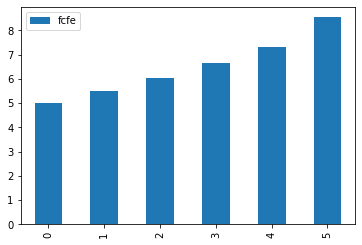

In [5]:
# example plot of future free cash flow to equity
pd.DataFrame({'fcfe': fcfe}).plot.bar()

In [6]:
rf = 0.02 # risk free rate
beta = 1.06 # equity beta
rm = 0.06 # market return
expected_return = [calculate_expected_return(rf, beta, rm),]*len(fcfe)
discount_factor = 1 / ((1 + np.array(expected_return)) ** np.arange(len(expected_return)))

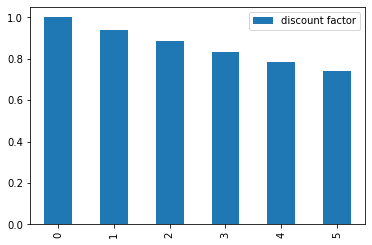

In [7]:
# example plot of discount factor future cash flow is discounted heavier than near term
pd.DataFrame({'discount factor': discount_factor}).plot.bar()

In [8]:
# NPV of future FCFE is the theoretical equity value
calc_npv(fcfe, expected_return)

33.13997627239179

## Bond DCF

In [9]:
def calculate_dis_rate(rf, spread):
    """
    Calculates the expected return using the CAPM model.
    
    Parameters:
    rf (float): Risk-free rate.
    beta (float): Beta of the security.
    rm (float): Expected return of the market.
    
    Returns:
    The expected return as a float.
    """
    return rf + spread

def bond_cf_projection(fv, coupon, period):
    """
    Calculates the fcfe projection
    
    Parameters:
    rf (float): Risk-free rate.
    beta (float): Beta of the security.
    rm (float): Expected return of the market.
    
    Returns:
    The expected return as a float.
    """
    cf = [fv * coupon, ] * period
    # change terminal payment to be principal payment
    cf[-1] = fv
    return cf

In [10]:
fv = 100 # face value of bond
coupon = 0.03 # 3% coupon per period
period = 10 # 10 year bond
cash_flows = bond_cf_projection(fv,coupon, period)
discount_rate = [calculate_dis_rate(0.02, 0.01),]*len(cash_flows)

calc_npv(cash_flows, discount_rate)

100.7007498029691

In [11]:
fv = 100 # face value of bond
coupon = 0.03 # 3% coupon per period
period = 10 # 10 year bond
cash_flows = bond_cf_projection(fv,coupon, period)

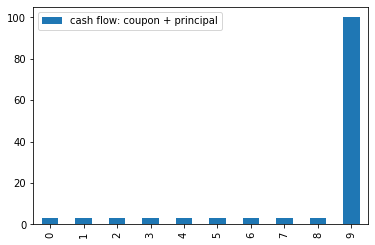

In [12]:
# example plot of cash flow of a bullet bond
pd.DataFrame({'cash flow: coupon + principal': cash_flows}).plot.bar()

In [13]:
rf = 0.02 # risk free rate
credit_spread = 0.01 # credit spread
discount_rate = [calculate_dis_rate(rf, credit_spread),]*len(cash_flows)
discount_factor = 1 / ((1 + np.array(discount_rate)) ** np.arange(len(discount_rate)))

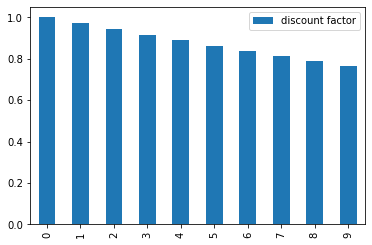

In [14]:
# example plot of discount factor: future cash flow is discounted heavier than near term
pd.DataFrame({'discount factor': discount_factor}).plot.bar()

In [15]:
# NPV of future cash flow is the theoretical bond value
calc_npv(cash_flows, discount_rate)

100.7007498029691

## Bond Duration Risk

In [16]:
# Define the input variables
fv = 100 # face value of bond
coupon = 0.05 # 5% coupon per period
period = 20 # 20 year bond
rf = 0.02 # risk free rate
credit_spread = 0.01 # credit spread

cash_flows = bond_cf_projection(fv,coupon, period)
discount_rate = [calculate_dis_rate(rf, credit_spread),]*len(cash_flows)
calc_npv(cash_flows, discount_rate)

130.79616807847867

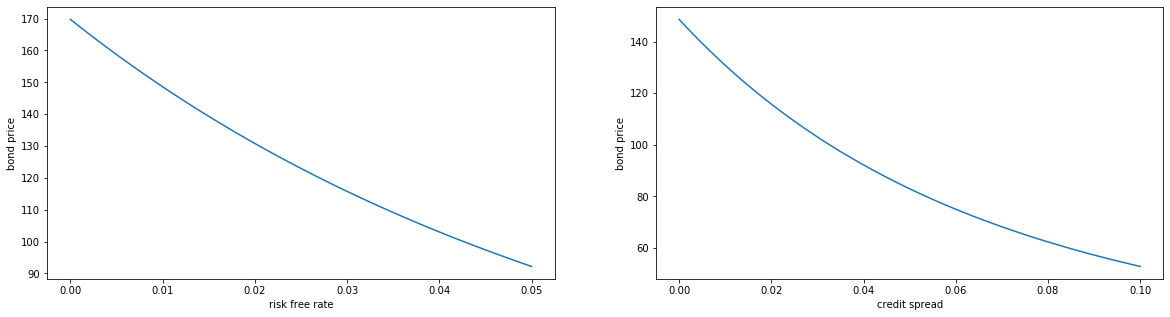

In [17]:
# Define a range of values to shock interest rate
rf_values = np.linspace(0, 0.05, 50)
credit_spread_values = np.linspace(0, 0.1, 50)

# Calculate the probability of default for each value in the range for each variable
price_duration = [calc_npv(cash_flows, [calculate_dis_rate(r, credit_spread),]*len(cash_flows)) for r in rf_values]
price_spread_duration = [calc_npv(cash_flows, [calculate_dis_rate(rf, cs),]*len(cash_flows)) for cs in credit_spread_values]

# Plot the sensitivity analysis for each variable
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(rf_values, price_duration)
axs[0].set_xlabel('risk free rate')
axs[0].set_ylabel('bond price')
axs[1].plot(credit_spread_values, price_spread_duration)
axs[1].set_xlabel('credit spread')
axs[1].set_ylabel('bond price')
plt.show()

## Merton Model

In [18]:
def merton_model(asset_value, liability, volatility, risk_free_rate, time_to_maturity):
    """
    Computes the probability of default for a company using the Merton model.
    
    :param asset_value: float, the value of the company's assets
    :param debt: float, the company's outstanding debt
    :param volatility: float, the volatility of the company's asset value
    :param risk_free_rate: float, the risk-free interest rate
    :param time_to_maturity: float, the time to maturity of the debt
    :return: float, the probability of default
    """
    
    d1 = (math.log(asset_value / liability) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * math.sqrt(time_to_maturity))
    d2 = d1 - volatility * math.sqrt(time_to_maturity)
    
    default_prob = 1- norm.cdf(d2)
    equity = asset_value * norm.cdf(d1) - liability * math.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)
    debt = liability * math.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2) + asset_value * norm.cdf(-d1)
    ytm = 1 / time_to_maturity * math.log(liability / debt)
    credit_spread = ytm - risk_free_rate
    
    return {'pd': default_prob, 
            'equity_val': equity, 
            'debt_val': debt, 
            'ytm': ytm, 
            'credit_spread': credit_spread}

In [19]:
# example
asset_value = 100
liability_fv = 75
asset_vol = 0.4
risk_free_rate = 0.05
t2m = 1

merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)

{'pd': 0.25972119580694564,
 'equity_val': 32.367352915441714,
 'debt_val': 67.6326470845583,
 'ytm': 0.10339730202996895,
 'credit_spread': 0.05339730202996895}

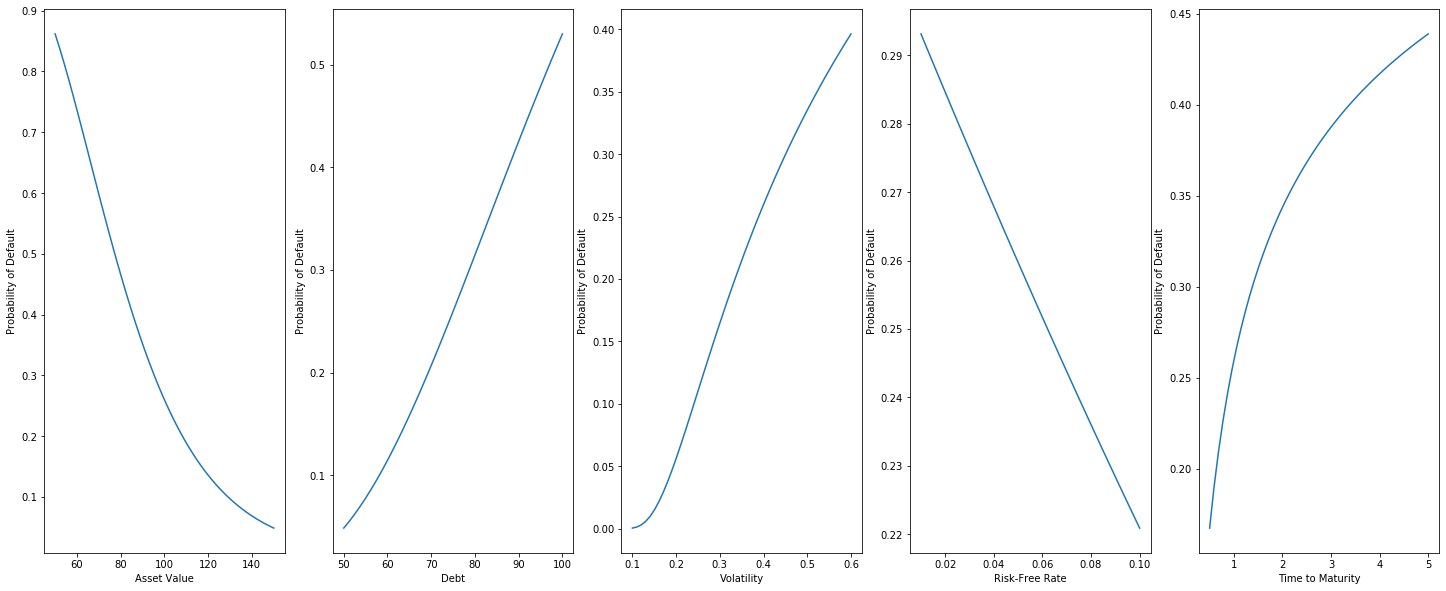

In [20]:
# Define the input variables
asset_value = 100
liability_fv = 75
asset_vol = 0.4
risk_free_rate = 0.05
t2m = 1

# Define a range of values to test for each variable
asset_values = np.linspace(50, 150, 50)
liability_fvs = np.linspace(50, 100, 50)
asset_vols = np.linspace(0.1, 0.6, 50)
risk_free_rates = np.linspace(0.01, 0.1, 50)
t2ms = np.linspace(0.5, 5, 50)

# Calculate the probability of default for each value in the range for each variable
default_probs_asset = [merton_model(asset, liability_fv, asset_vol, risk_free_rate, t2m)['pd'] for asset in asset_values]
default_probs_debt = [merton_model(asset_value, d, asset_vol, risk_free_rate, t2m)['pd'] for d in liability_fvs]
default_probs_volatility = [merton_model(asset_value, liability_fv, vol, risk_free_rate, t2m)['pd'] for vol in asset_vols]
default_probs_risk_free_rate = [merton_model(asset_value, liability_fv, asset_vol, r, t2m)['pd'] for r in risk_free_rates]
default_probs_time_to_maturity = [merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t)['pd'] for t in t2ms]

# Plot the sensitivity analysis for each variable
fig, axs = plt.subplots(1, 5, figsize=(25, 10))
axs[0].plot(asset_values, default_probs_asset)
axs[0].set_xlabel('Asset Value')
axs[0].set_ylabel('Probability of Default')
axs[1].plot(liability_fvs, default_probs_debt)
axs[1].set_xlabel('Debt')
axs[1].set_ylabel('Probability of Default')
axs[2].plot(asset_vols, default_probs_volatility)
axs[2].set_xlabel('Volatility')
axs[2].set_ylabel('Probability of Default')
axs[3].plot(risk_free_rates, default_probs_risk_free_rate)
axs[3].set_xlabel('Risk-Free Rate')
axs[3].set_ylabel('Probability of Default')
axs[4].plot(t2ms, default_probs_time_to_maturity)
axs[4].set_xlabel('Time to Maturity')
axs[4].set_ylabel('Probability of Default')
plt.show()

# Climate Risk Integration

In [21]:
# example oil&gas
asset_value = 100
liability_fv = 50
asset_vol = 0.4
risk_free_rate = 0.05
t2m = 1

merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)

{'pd': 0.04867206107760935,
 'equity_val': 52.773303059945455,
 'debt_val': 47.22669694005454,
 'ytm': 0.05706365959870682,
 'credit_spread': 0.00706365959870682}

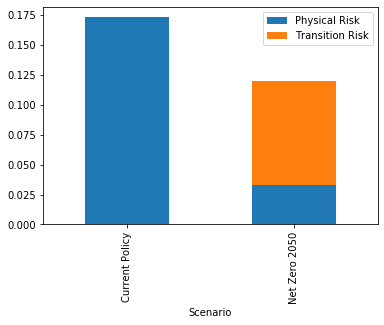

In [22]:
# impact on PD
df = pd.DataFrame({'Physical Risk': [merton_model(asset_value*0.7, liability_fv, asset_vol, risk_free_rate, t2m)['pd'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['pd'], 
                                     merton_model(asset_value*0.9, liability_fv, asset_vol, risk_free_rate, t2m)['pd'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['pd']],
                   'Transition Risk': [merton_model(asset_value*1, liability_fv, asset_vol, risk_free_rate, t2m)['pd'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['pd'], 
                                     merton_model(asset_value*0.8, liability_fv, asset_vol, risk_free_rate, t2m)['pd'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['pd']],
                   'Scenario': ['Current Policy', 'Net Zero 2050']
                  })
df.set_index('Scenario').plot(kind='bar', stacked=True)

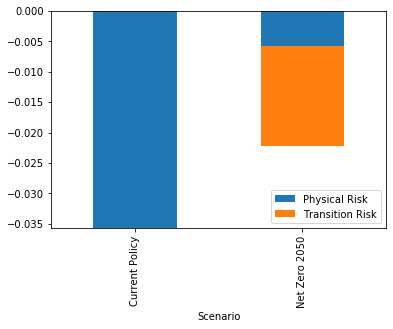

In [23]:
# impact on bond price
df = pd.DataFrame({'Physical Risk': [(merton_model(asset_value*0.7, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'], 
                                     (merton_model(asset_value*0.9, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val']],
                   'Transition Risk': [(merton_model(asset_value*1, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'], 
                                     (merton_model(asset_value*0.8, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val'])/ merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['debt_val']],
                   'Scenario': ['Current Policy', 'Net Zero 2050']
                  })
df.set_index('Scenario').plot(kind='bar', stacked=True)

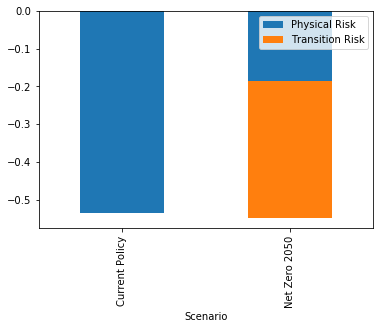

In [24]:
# impact on equity price
df = pd.DataFrame({'Physical Risk': [(merton_model(asset_value*0.7, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'], 
                                     (merton_model(asset_value*0.9, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val']],
                   'Transition Risk': [(merton_model(asset_value*1, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val']) / merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'], 
                                     (merton_model(asset_value*0.8, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'] - merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val'])/ merton_model(asset_value, liability_fv, asset_vol, risk_free_rate, t2m)['equity_val']],
                   'Scenario': ['Current Policy', 'Net Zero 2050']
                  })
df.set_index('Scenario').plot(kind='bar', stacked=True)